In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
from os.path import join
import torch
import torch as th
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom, PixArtAlphaPipeline_custom_CLIP
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Pleas

In [4]:
from jingxuan.prompt_ablation_experiments.head_attention_masking import \
    HeadSpecificAttentionProcessor, PixArtAlphaPipeline_HeadMask, visualize_prompt_with_head_masking

In [6]:
from typing import Union, List, Optional


class PixArtAlphaPipeline_HeadMask_CLIP(PixArtAlphaPipeline_HeadMask):
    """Slightly modify the encode_prompt function to use the text encoder of CLIP"""

    def encode_prompt(
        self,
        prompt: Union[str, List[str]],
        do_classifier_free_guidance: bool = True,
        negative_prompt: str = "",
        num_images_per_prompt: int = 1,
        device: Optional[torch.device] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        prompt_attention_mask: Optional[torch.Tensor] = None,
        negative_prompt_attention_mask: Optional[torch.Tensor] = None,
        clean_caption: bool = False,
        max_sequence_length: int = 120,
        **kwargs,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt not to guide the image generation. If not defined, one has to pass `negative_prompt_embeds`
                instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is less than `1`). For
                PixArt-Alpha, this should be "".
            do_classifier_free_guidance (`bool`, *optional*, defaults to `True`):
                whether to use classifier free guidance or not
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                number of images that should be generated per prompt
            device: (`torch.device`, *optional*):
                torch device to place the resulting embeddings on
            prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated negative text embeddings. For PixArt-Alpha, it's should be the embeddings of the ""
                string.
            clean_caption (`bool`, defaults to `False`):
                If `True`, the function will preprocess and clean the provided caption before encoding.
            max_sequence_length (`int`, defaults to 120): Maximum sequence length to use for the prompt.
        """

        # if "mask_feature" in kwargs:
        #     deprecation_message = "The use of `mask_feature` is deprecated. It is no longer used in any computation and that doesn't affect the end results. It will be removed in a future version."
        #     deprecate("mask_feature", "1.0.0", deprecation_message, standard_warn=False)

        if device is None:
            device = self._execution_device

        # See Section 3.1. of the paper.
        max_length = max_sequence_length

        if prompt_embeds is None:
            prompt = self._text_preprocessing(prompt, clean_caption=clean_caption)
            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                add_special_tokens=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                text_input_ids, untruncated_ids
            ):
                removed_text = self.tokenizer.batch_decode(untruncated_ids[:, max_length - 1 : -1])

            prompt_attention_mask = text_inputs.attention_mask
            prompt_attention_mask = prompt_attention_mask.to(device)

            prompt_embeds_outputs = self.text_encoder(text_input_ids.to(device), attention_mask=prompt_attention_mask)
            prompt_embeds = prompt_embeds_outputs.last_hidden_state

        if self.text_encoder is not None:
            dtype = self.text_encoder.dtype
        elif self.transformer is not None:
            dtype = self.transformer.dtype
        else:
            dtype = None

        prompt_embeds = prompt_embeds.to(dtype=dtype, device=device)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings and attention mask for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)
        prompt_attention_mask = prompt_attention_mask.repeat(1, num_images_per_prompt)
        prompt_attention_mask = prompt_attention_mask.view(bs_embed * num_images_per_prompt, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens = [negative_prompt] * bs_embed if isinstance(negative_prompt, str) else negative_prompt
            uncond_tokens = self._text_preprocessing(uncond_tokens, clean_caption=clean_caption)
            max_length = prompt_embeds.shape[1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_attention_mask=True,
                add_special_tokens=True,
                return_tensors="pt",
            )
            negative_prompt_attention_mask = uncond_input.attention_mask
            negative_prompt_attention_mask = negative_prompt_attention_mask.to(device)

            negative_prompt_embeds_outputs = self.text_encoder(
                uncond_input.input_ids.to(device), attention_mask=negative_prompt_attention_mask
            )
            negative_prompt_embeds = negative_prompt_embeds_outputs.last_hidden_state

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.to(dtype=dtype, device=device)

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

            negative_prompt_attention_mask = negative_prompt_attention_mask.repeat(1, num_images_per_prompt)
            negative_prompt_attention_mask = negative_prompt_attention_mask.view(bs_embed * num_images_per_prompt, -1)
        else:
            negative_prompt_embeds = None
            negative_prompt_attention_mask = None

        return prompt_embeds, prompt_attention_mask, negative_prompt_embeds, negative_prompt_attention_mask


In [7]:
from transformers import CLIPTextModelWithProjection, CLIPTokenizer
# Load SDXL's text encoder and tokenizer (text_encoder_2 and tokenizer_2)
text_encoder = CLIPTextModelWithProjection.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="text_encoder_2", 
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",)
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="tokenizer_2", 
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",)

In [8]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_CLIPemb_DiT_mini_pilot"

config = read_config(join(savedir, 'config.py'))

weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length, "caption_channels": config.caption_channels}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()

transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=config.caption_channels,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_HeadMask_CLIP.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

pipeline.tokenizer = tokenizer
pipeline.to(device="cuda", dtype=weight_dtype);
# pipeline.to(device="cuda", dtype=torch.bfloat16);
pipeline.text_encoder = text_encoder.to(device="cuda", )

2026-01-25 22:03:47,154 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.


In [9]:
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))

/tmp/ipykernel_2644822/1495998778.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))


<All keys matched successfully>

In [12]:
def visualize_prompt_with_head_masking(pipeline, prompt, max_length=120, weight_dtype=torch.bfloat16,
                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, num_image_to_plot=0, 
                   device="cuda", random_seed=0, target_layer_idx=None, target_head_indices=None, 
                   manipulated_mask_func=None, **mask_kwargs):
    """
    Generate images with head-specific attention masking
    
    Args:
        pipeline: The PixArtAlphaPipeline_HeadMask instance
        prompt: Text prompt for generation
        max_length: Maximum sequence length
        weight_dtype: Weight data type
        num_inference_steps: Number of denoising steps
        guidance_scale: CFG guidance scale
        num_images_per_prompt: Number of images to generate
        num_image_to_plot: Which image to plot in trajectory
        device: Device to run on
        random_seed: Random seed for reproducibility
        target_layer_idx: Which transformer layer to apply head masking to (single int)
        target_head_indices: Which attention heads within the target layer to mask (list of ints)
        manipulated_mask_func: Function to generate the head-specific attention mask
        **mask_kwargs: Additional arguments for the mask function
    """
    pipeline = pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)
    if random_seed is None:
        generator = None
    else:
        generator = torch.Generator(device=device).manual_seed(random_seed)
    
    # Tokenize the prompt
    inputs = pipeline.tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=max_length).to(device)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    
    # Generate head-specific attention mask if specified
    head_attention_mask = None
    if target_layer_idx is not None and target_head_indices is not None and manipulated_mask_func is not None:
        print(f"Applying {manipulated_mask_func.__name__} to layer {target_layer_idx}, heads {target_head_indices}")
        head_attention_mask = manipulated_mask_func(prompt, pipeline.tokenizer, max_length, device, **mask_kwargs)
    
    # Get text embeddings
    text_embeddings = pipeline.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    
    output = pipeline(
        num_inference_steps=num_inference_steps,
        num_images_per_prompt=num_images_per_prompt,
        generator=generator,
        guidance_scale=guidance_scale,
        prompt_embeds=text_embeddings,
        prompt_attention_mask=attention_mask,
        negative_prompt="",
        negative_prompt_embeds=None,
        negative_prompt_attention_mask=None,
        use_resolution_binning=False,
        return_sample_pred_traj=True,
        output_type="latent",
        target_layer_idx=target_layer_idx,
        target_head_indices=target_head_indices,
        head_attention_mask=head_attention_mask,
    )
    
    latents = output[0].images
    pred_traj = output[1]
    latents_traj = output[2]
    t_traj = output[3]
    denoiser_traj = output[4]
    
    # Decode latents to images
    images = pipeline.vae.decode(latents.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0]
    images = pipeline.image_processor.postprocess(images.detach(), output_type="pil")
    
    return {"prompt": prompt, "images": images}, latents_traj, pred_traj, t_traj, denoiser_traj

In [85]:
figroot = "/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/DiT_CLIP_attn_head_ablation_figures/"
figdir = join(figroot, "DiT_mini")

### Head masking 

In [ ]:
from utils.mask_attention_utils import get_meaningful_token_indices, \
    mask_semantic_parts_attention, mask_all_attention, mask_padding_attention

  0%|          | 0/14 [00:00<?, ?it/s]

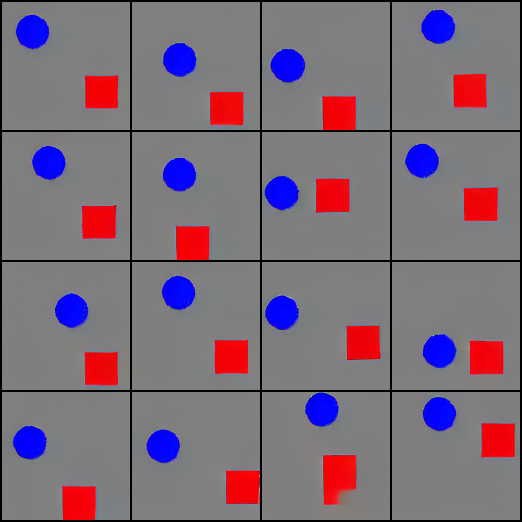

In [10]:
prompt = "red square is below and to the right of the blue circle"

output = pipeline(prompt=prompt,
        num_inference_steps=14,
        max_sequence_length=20, 
        generator=torch.Generator(device="cuda").manual_seed(42),
        guidance_scale=4.5,
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
noise_pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

Applying mask_all_attention to layer 0, heads [2]
Setting up head masking for layer 0, heads: [2]


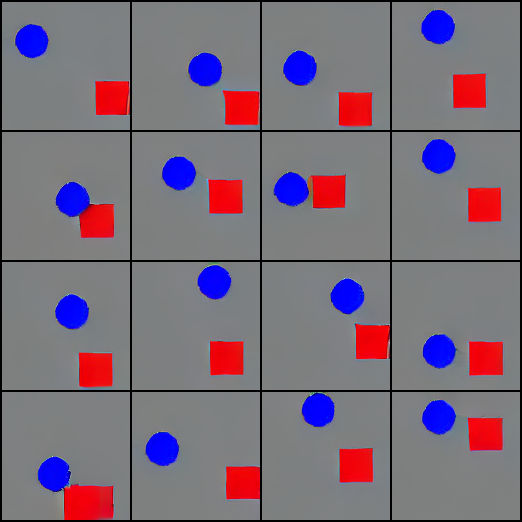

In [28]:
output = \
    visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, 
                                    weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, 
                                   num_images_per_prompt=16, 
                                   device="cuda", random_seed=42, target_layer_idx=0, target_head_indices=[2], 
                                   manipulated_mask_func=mask_all_attention, )

# display(output[0]["images"][0])
display(pil_images_to_grid(output[0]["images"]))

Applying mask_all_attention to layer 0, heads [5]
Setting up head masking for layer 0, heads: [5]


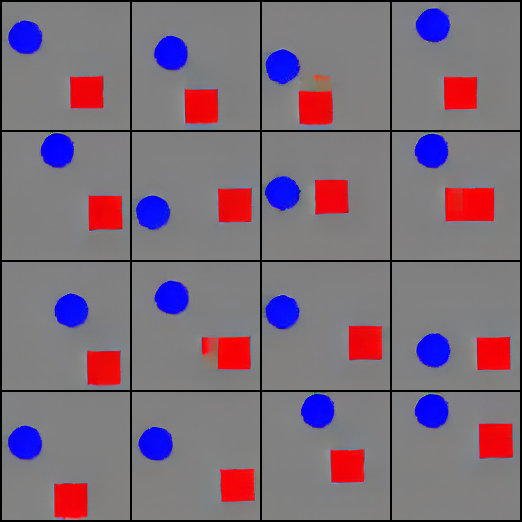

In [27]:
output = \
    visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, 
                                    weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, 
                                   num_images_per_prompt=16, 
                                   device="cuda", random_seed=42, target_layer_idx=0, target_head_indices=[5], 
                                   manipulated_mask_func=mask_all_attention, )

# display(output[0]["images"][0])
display(pil_images_to_grid(output[0]["images"]))

Applying mask_all_attention to layer 0, heads [2, 5]
Setting up head masking for layer 0, heads: [2, 5]
red square is below and to the right of the blue circle


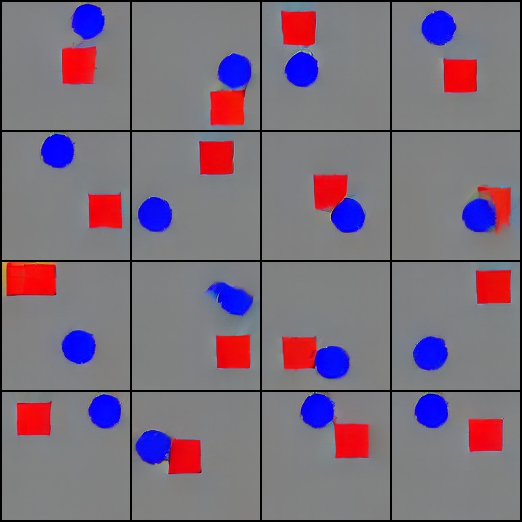

In [25]:
output = \
    visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, 
                                    weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=16, 
                                   device="cuda", random_seed=42, target_layer_idx=0, target_head_indices=[2,5], 
                                   manipulated_mask_func=mask_all_attention, )
print(prompt)
display(pil_images_to_grid(output[0]["images"]))

Applying mask_all_attention to layer 0, heads []
Setting up head masking for layer 0, heads: []
red square is below and to the right of the blue circle


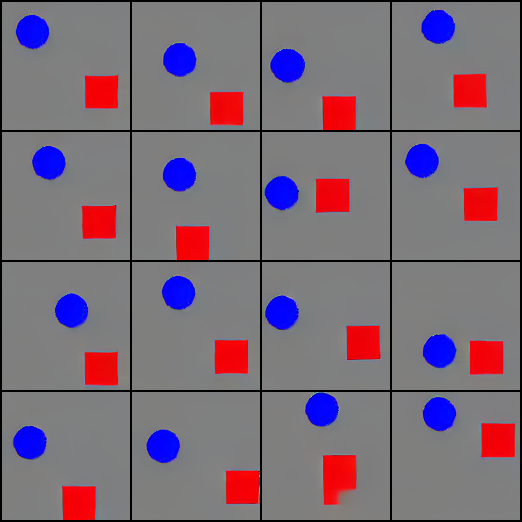

In [26]:
output = \
    visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, 
                                    weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=16, 
                                   device="cuda", random_seed=42, target_layer_idx=0, target_head_indices=[], 
                                   manipulated_mask_func=mask_all_attention, )
print(prompt)
display(pil_images_to_grid(output[0]["images"]))

Applying mask_all_attention to layer 2, heads [2]
Setting up head masking for layer 2, heads: [2]
red square is below and to the right of the blue circle


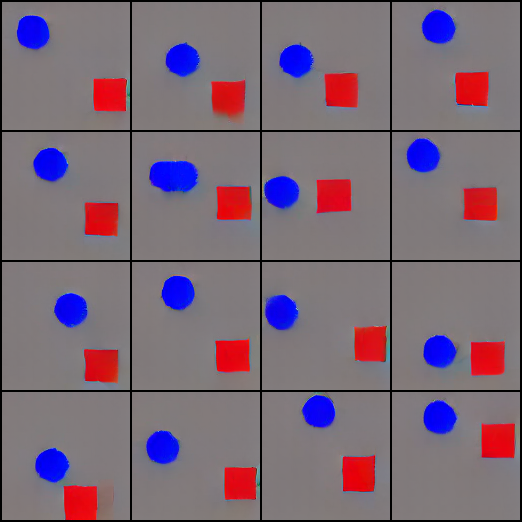

In [29]:
output = \
    visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, 
                                    weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=16, 
                                   device="cuda", random_seed=42, target_layer_idx=2, target_head_indices=[2], 
                                   manipulated_mask_func=mask_all_attention, )
print(prompt)
display(pil_images_to_grid(output[0]["images"]))

Applying mask_all_attention to layer 2, heads [5]
Setting up head masking for layer 2, heads: [5]
red square is below and to the right of the blue circle


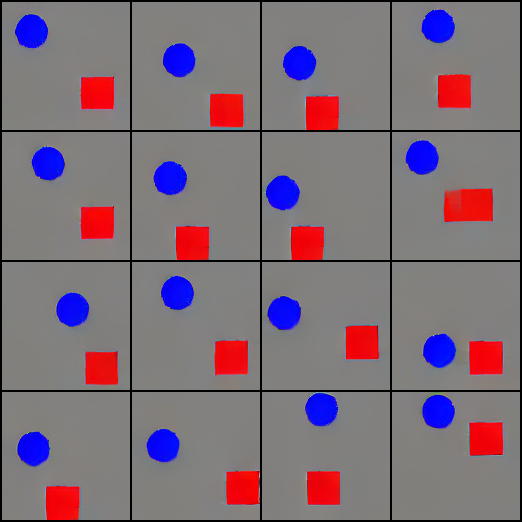

In [30]:
output = \
    visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, 
                                    weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=16, 
                                   device="cuda", random_seed=42, target_layer_idx=2, target_head_indices=[5], 
                                   manipulated_mask_func=mask_all_attention, )
print(prompt)
display(pil_images_to_grid(output[0]["images"]))

Applying mask_all_attention to layer 2, heads [2, 5]
Setting up head masking for layer 2, heads: [2, 5]
red square is below and to the right of the blue circle


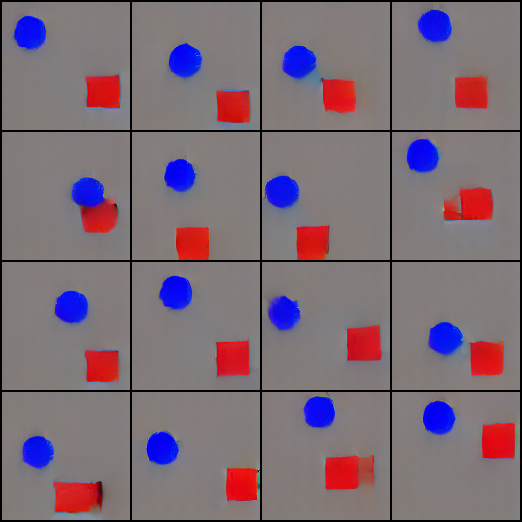

In [31]:
output = \
    visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, 
                                    weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=16, 
                                   device="cuda", random_seed=42, target_layer_idx=2, target_head_indices=[2,5], 
                                   manipulated_mask_func=mask_all_attention, )
print(prompt)
display(pil_images_to_grid(output[0]["images"]))

### Systematic eval 

In [48]:
from utils.cv2_eval_utils import print_evaluation_summary_concise
from utils.cv2_eval_utils import find_classify_objects, evaluate_parametric_relation

def evaluate_images(images, prompt, scene_info, color_margin=25, spatial_threshold=5, ):
    prompt_id = 0
    all_eval_results = []
    all_object_results = []
    for sample_id, image in enumerate(images):
        try:
            # Detect and classify objects in the image
            classified_objects_df = find_classify_objects(image)
            
            # Evaluate spatial relationships
            eval_result = evaluate_parametric_relation(
                classified_objects_df, scene_info, 
                color_margin=color_margin, 
                spatial_threshold=spatial_threshold
            )
            
            # Create evaluation record
            eval_record = {
                "prompt_id": prompt_id,
                "prompt": prompt,
                "sample_id": sample_id,
                **eval_result,
                # **scene_info  # Add scene info columns
            }
            all_eval_results.append(eval_record)
            
            # Store object detection results
            classified_objects_df["prompt_id"] = prompt_id
            classified_objects_df["sample_id"] = sample_id
            classified_objects_df["prompt"] = prompt
            all_object_results.append(classified_objects_df)
            
        except Exception as e:
            print(f"Error evaluating sample {sample_id} for prompt '{prompt}': {e}")
            continue

    # Convert to DataFrames
    eval_df = pd.DataFrame(all_eval_results)
    object_df = pd.concat(all_object_results, ignore_index=True) if all_object_results else pd.DataFrame()
    return eval_df, object_df

In [49]:
from utils.relation_shape_dataset_lib import ShapesDataset
dataset_tmp = ShapesDataset(num_images=10000)
dataset_tmp.spatial_phrases,

({'upper_left': ['to the upper left of',
   'above and to the left of',
   'diagonally up and left from'],
  'upper_right': ['to the upper right of',
   'above and to the right of',
   'diagonally up and right from'],
  'lower_left': ['to the lower left of',
   'below and to the left of',
   'diagonally down and left from'],
  'lower_right': ['to the lower right of',
   'below and to the right of',
   'diagonally down and right from'],
  'above': ['above', 'directly above', 'higher than'],
  'below': ['below', 'directly below', 'lower than'],
  'left': ['to the left of', 'left of'],
  'right': ['to the right of', 'right of'],
  'in_front': ['in front of', 'overlapping and in front of'],
  'behind': ['behind', 'overlapped by']},)

In [50]:
prompt
scene_info = {"color1": "red", "shape1": "square", "color2": "blue", "shape2": "circle", "spatial_relationship": "lower_right"}
eval_df, object_df = evaluate_images(output[0]["images"], prompt, scene_info, color_margin=25, spatial_threshold=5)

Applying mask_all_attention to layer 2, heads []
Setting up head masking for layer 2, heads: []
red square is below and to the right of the blue circle


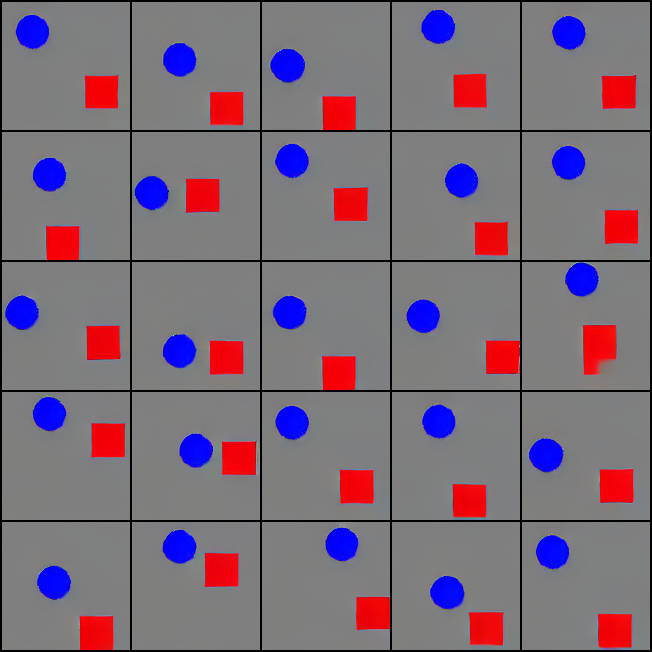

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.92           0.92   0.96    1.0           0.96            0.96   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                  0.92                        0.92  50.292  46.833  92.208   

       y1      x2    y2  
0  91.333  41.917  44.5

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.92           0.92   0.96    1.0           0.96            0.96   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                  0.92                        0.92  50.292  46.833  92.208   

       y1      x2    y2  
0  91.333  41.917  44.5

In [53]:
output = visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, 
                                   device="cuda", random_seed=42, target_layer_idx=2, target_head_indices=[], 
                                   manipulated_mask_func=mask_all_attention, )
print(prompt)
display(pil_images_to_grid(output[0]["images"]))
eval_df, object_df = evaluate_images(output[0]["images"], prompt, scene_info, color_margin=25, spatial_threshold=5)
display(print_evaluation_summary_concise(eval_df))

Applying mask_all_attention to layer 0, heads [2]
Setting up head masking for layer 0, heads: [2]
red square is below and to the right of the blue circle


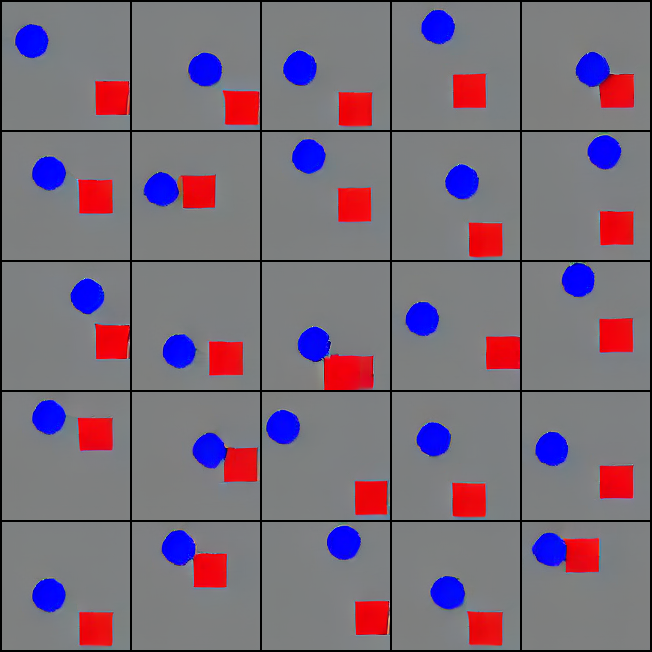

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.84           0.84   0.96   0.92           0.88            0.88   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                  0.84                        0.84  44.182  41.182  92.955   

     y1      x2      y2  
0  85.0  48.773  43.818

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.84           0.84   0.96   0.92           0.88            0.88   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                  0.84                        0.84  44.182  41.182  92.955   

     y1      x2      y2  
0  85.0  48.773  43.818

In [54]:
output = visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, 
                                   device="cuda", random_seed=42, target_layer_idx=0, target_head_indices=[2], 
                                   manipulated_mask_func=mask_all_attention, )
print(prompt)
display(pil_images_to_grid(output[0]["images"]))
eval_df, object_df = evaluate_images(output[0]["images"], prompt, scene_info, color_margin=25, spatial_threshold=5)
display(print_evaluation_summary_concise(eval_df))

Applying mask_all_attention to layer 0, heads [5]
Setting up head masking for layer 0, heads: [5]
red square is below and to the right of the blue circle


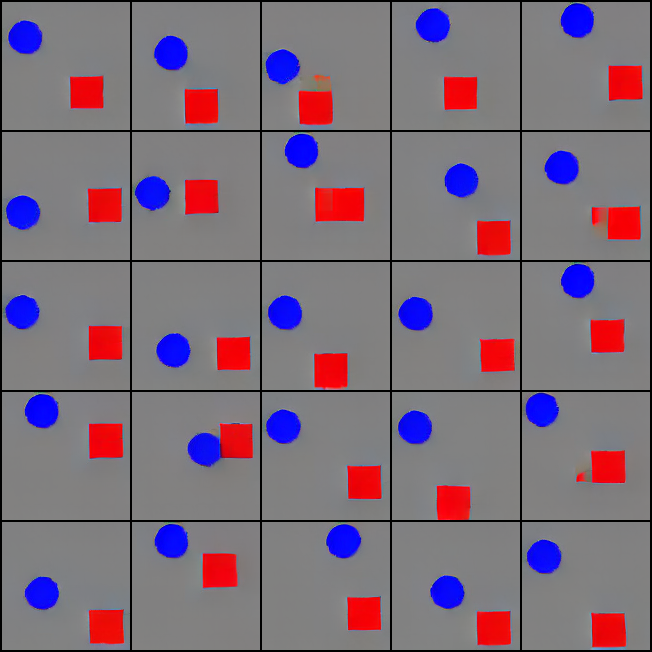

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0      0.8            0.8   0.96   0.96           0.92            0.92   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                   0.8                         0.8  53.174  45.304  89.217   

       y1      x2      y2  
0  88.348  36.043  43.043

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0      0.8            0.8   0.96   0.96           0.92            0.92   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                   0.8                         0.8  53.174  45.304  89.217   

       y1      x2      y2  
0  88.348  36.043  43.043

In [55]:
output = visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, 
                                   device="cuda", random_seed=42, target_layer_idx=0, target_head_indices=[5], 
                                   manipulated_mask_func=mask_all_attention, )
print(prompt)
display(pil_images_to_grid(output[0]["images"]))
eval_df, object_df = evaluate_images(output[0]["images"], prompt, scene_info, color_margin=25, spatial_threshold=5)
display(print_evaluation_summary_concise(eval_df))

Applying mask_all_attention to layer 2, heads [2]
Setting up head masking for layer 2, heads: [2]
red square is below and to the right of the blue circle


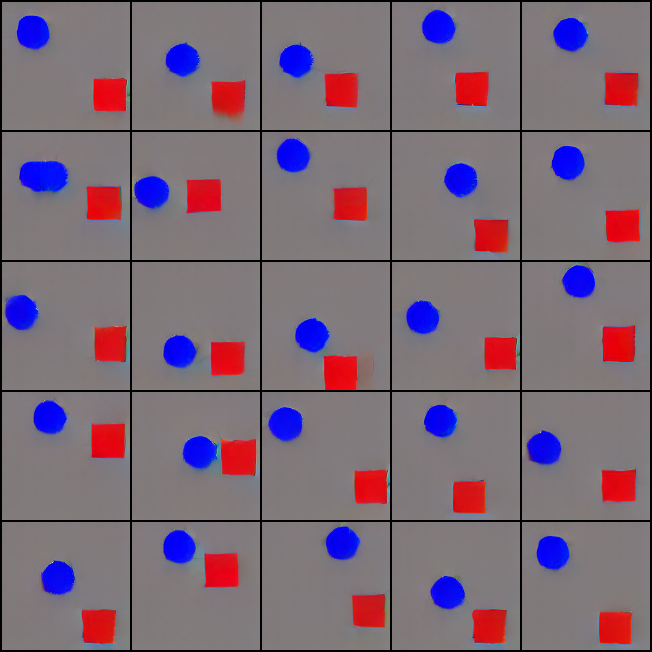

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.04           0.04   0.96   0.04           0.04            0.04   

   spatial_relationship  spatial_relationship_loose    Dx    Dy     x1    y1  \
0                  0.04                        0.04  76.0  63.0  107.0  93.0   

     x2    y2  
0  31.0  30.0

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.04           0.04   0.96   0.04           0.04            0.04   

   spatial_relationship  spatial_relationship_loose    Dx    Dy     x1    y1  \
0                  0.04                        0.04  76.0  63.0  107.0  93.0   

     x2    y2  
0  31.0  30.0

In [60]:
output = visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, 
                                   device="cuda", random_seed=42, target_layer_idx=2, target_head_indices=[2], 
                                   manipulated_mask_func=mask_all_attention, )
print(prompt)
display(pil_images_to_grid(output[0]["images"]))
eval_df, object_df = evaluate_images(output[0]["images"], prompt, scene_info, color_margin=25, spatial_threshold=5)
display(print_evaluation_summary_concise(eval_df))

Applying mask_all_attention to layer 1, heads [2]
Setting up head masking for layer 1, heads: [2]
red square is below and to the right of the blue circle


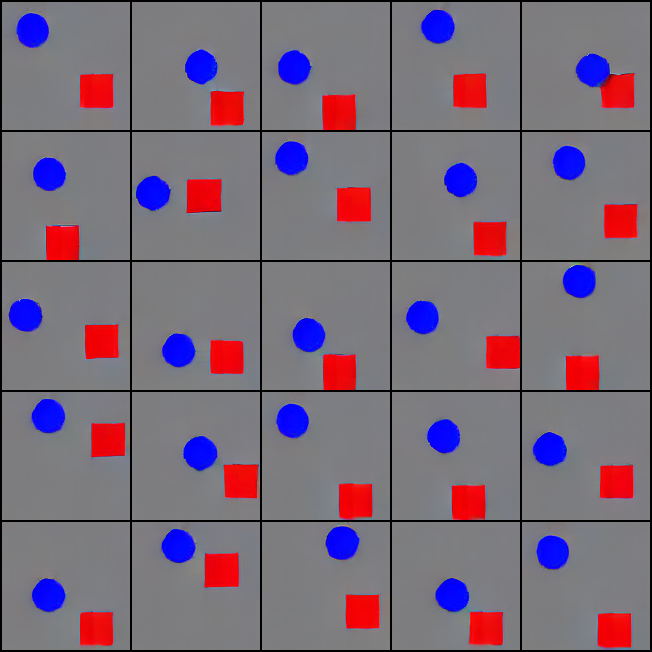

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.88           0.88   0.96    1.0           0.96            0.96   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                  0.88                        0.88  45.167  46.375  90.083   

       y1      x2      y2  
0  92.667  44.917  46.292

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.88           0.88   0.96    1.0           0.96            0.96   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                  0.88                        0.88  45.167  46.375  90.083   

       y1      x2      y2  
0  92.667  44.917  46.292

In [61]:
output = visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, 
                                   device="cuda", random_seed=42, target_layer_idx=1, target_head_indices=[2], 
                                   manipulated_mask_func=mask_all_attention, )
print(prompt)
display(pil_images_to_grid(output[0]["images"]))
eval_df, object_df = evaluate_images(output[0]["images"], prompt, scene_info, color_margin=25, spatial_threshold=5)
display(print_evaluation_summary_concise(eval_df))

Applying mask_all_attention to layer 0, heads [2, 5]
Setting up head masking for layer 0, heads: [2, 5]
red square is below and to the right of the blue circle


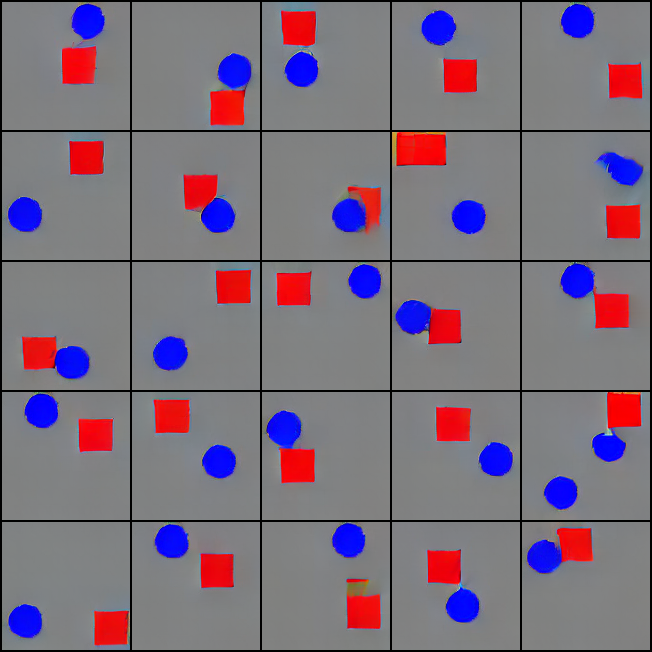

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.32           0.32   0.84   0.92            0.8            0.76   

   spatial_relationship  spatial_relationship_loose      Dx     Dy      x1  \
0                  0.32                        0.32  13.421  5.579  71.474   

     y1      x2      y2  
0  54.0  58.053  48.421

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.32           0.32   0.84   0.92            0.8            0.76   

   spatial_relationship  spatial_relationship_loose      Dx     Dy      x1  \
0                  0.32                        0.32  13.421  5.579  71.474   

     y1      x2      y2  
0  54.0  58.053  48.421

In [56]:
output = visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, weight_dtype=torch.float16,
                                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, 
                                   device="cuda", random_seed=42, target_layer_idx=0, target_head_indices=[2,5], 
                                   manipulated_mask_func=mask_all_attention, )
print(prompt)
display(pil_images_to_grid(output[0]["images"]))
eval_df, object_df = evaluate_images(output[0]["images"], prompt, scene_info, color_margin=25, spatial_threshold=5)
display(print_evaluation_summary_concise(eval_df))

In [71]:
print(prompt)
images_results = []
head_ablation_results = []
head_ablation_synopses = []
for target_layer, target_head_indices in [(0, []), 
                                          (0, [2]), 
                                          (0, [5]), 
                                          (0, [2,5]), 
                                          ]:
    output = visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, weight_dtype=torch.float16,
                                    num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, 
                                    device="cuda", random_seed=42, target_layer_idx=target_layer, target_head_indices=target_head_indices, 
                                    manipulated_mask_func=mask_all_attention, )
    # print(prompt)
    # display(pil_images_to_grid(output[0]["images"]))
    eval_df, object_df = evaluate_images(output[0]["images"], prompt, scene_info, color_margin=25, spatial_threshold=5)
    print("Layer: ", target_layer, "Heads: ", target_head_indices)
    display(print_evaluation_summary_concise(eval_df))
    images_results.append(output[0]["images"])
    eval_df = eval_df.assign(target_layer=target_layer,
                            target_head_indices=[tuple(target_head_indices)] * len(eval_df))
    head_ablation_results.append(eval_df)
    head_ablation_synopses.append(print_evaluation_summary_concise(eval_df))
head_ablation_results = pd.concat(head_ablation_results)

red square is below and to the right of the blue circle
Applying mask_all_attention to layer 0, heads []
Setting up head masking for layer 0, heads: []
Layer:  0 Heads:  []


overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.92           0.92   0.96    1.0           0.96            0.96   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                  0.92                        0.92  50.125  46.875  92.167   

       y1      x2    y2  
0  91.375  42.042  44.5

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.92           0.92   0.96    1.0           0.96            0.96   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                  0.92                        0.92  50.125  46.875  92.167   

       y1      x2    y2  
0  91.375  42.042  44.5

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.92           0.92   0.96    1.0           0.96            0.96   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                  0.92                        0.92  50.125  46.875  92.167   

       y1      x2    y2  target_layer  
0  91.375  42.042  44.5           0.0

Applying mask_all_attention to layer 0, heads [2]
Setting up head masking for layer 0, heads: [2]
Layer:  0 Heads:  [2]


overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.84           0.84   0.96   0.92           0.88            0.88   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                  0.84                        0.84  44.182  41.182  92.955   

     y1      x2      y2  
0  85.0  48.773  43.818

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.84           0.84   0.96   0.92           0.88            0.88   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                  0.84                        0.84  44.182  41.182  92.955   

     y1      x2      y2  
0  85.0  48.773  43.818

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.84           0.84   0.96   0.92           0.88            0.88   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                  0.84                        0.84  44.182  41.182  92.955   

     y1      x2      y2  target_layer  
0  85.0  48.773  43.818           0.0

Applying mask_all_attention to layer 0, heads [5]
Setting up head masking for layer 0, heads: [5]
Layer:  0 Heads:  [5]


overall  overall_loose  shape  color  exist_binding  unique_binding  \
0      0.8            0.8   0.96   0.96           0.92            0.92   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                   0.8                         0.8  53.174  45.304  89.217   

       y1      x2      y2  
0  88.348  36.043  43.043

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0      0.8            0.8   0.96   0.96           0.92            0.92   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                   0.8                         0.8  53.174  45.304  89.217   

       y1      x2      y2  
0  88.348  36.043  43.043

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0      0.8            0.8   0.96   0.96           0.92            0.92   

   spatial_relationship  spatial_relationship_loose      Dx      Dy      x1  \
0                   0.8                         0.8  53.174  45.304  89.217   

       y1      x2      y2  target_layer  
0  88.348  36.043  43.043           0.0

Applying mask_all_attention to layer 0, heads [2, 5]
Setting up head masking for layer 0, heads: [2, 5]
Layer:  0 Heads:  [2, 5]


overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.32           0.32   0.84   0.92            0.8            0.76   

   spatial_relationship  spatial_relationship_loose      Dx     Dy      x1  \
0                  0.32                        0.32  13.421  5.579  71.474   

     y1      x2      y2  
0  54.0  58.053  48.421

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.32           0.32   0.84   0.92            0.8            0.76   

   spatial_relationship  spatial_relationship_loose      Dx     Dy      x1  \
0                  0.32                        0.32  13.421  5.579  71.474   

     y1      x2      y2  
0  54.0  58.053  48.421

overall  overall_loose  shape  color  exist_binding  unique_binding  \
0     0.32           0.32   0.84   0.92            0.8            0.76   

   spatial_relationship  spatial_relationship_loose      Dx     Dy      x1  \
0                  0.32                        0.32  13.421  5.579  71.474   

     y1      x2      y2  target_layer  
0  54.0  58.053  48.421           0.0

In [79]:
# eval_df.select_dtypes(include=['number', 'bool']).drop(columns=['prompt_id', 'sample_id'], errors='ignore').mean().round(3).to_frame().T
head_ablation_summary = head_ablation_results.groupby(["target_layer", "target_head_indices"], sort=False).\
    mean(numeric_only=True).drop(columns=['prompt_id', 'sample_id'], errors='ignore').round(3)
display(head_ablation_summary)

overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                      0.92           0.92   0.96   1.00   
             (2,)                    0.84           0.84   0.96   0.92   
             (5,)                    0.80           0.80   0.96   0.96   
             (2, 5)                  0.32           0.32   0.84   0.92   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                            0.96            0.96   
             (2,)                          0.88            0.88   
             (5,)                          0.92            0.92   
             (2, 5)                        0.80            0.76   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                   0.92   
             (2,)                                 0.84   
             (5,)                                 0.80   
             (2, 5)                               0.32   

                                  spatial_relationship_loose      Dx      Dy  \
target_layer target_head_indices                                               
0            ()                                         0.92  50.125  46.875   
             (2,)                                       0.84  44.182  41.182   
             (5,)                                       0.80  53.174  45.304   
             (2, 5)                                     0.32  13.421   5.579   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   92.167  91.375  42.042  44.500  
             (2,)                 92.955  85.000  48.773  43.818  
             (5,)                 89.217  88.348  36.043  43.043  
             (2, 5)               71.474  54.000  58.053  48.421

In [94]:
head_ablation_results.to_csv(join(figdir, f"head_ablation_eval_results_L0H25_{prompt}.csv"), index=False)
head_ablation_results.to_pickle(join(figdir, f"head_ablation_eval_results_L0H25_{prompt}.pkl"))
head_ablation_summary.to_csv(join(figdir, f"head_ablation_summary_L0H25_{prompt}.csv"), index=False)
head_ablation_summary.to_pickle(join(figdir, f"head_ablation_summary_L0H25_{prompt}.pkl"))

In [ ]:
from circuit_toolkit.plot_utils import saveallforms
import seaborn as sns
import matplotlib.pyplot as plt

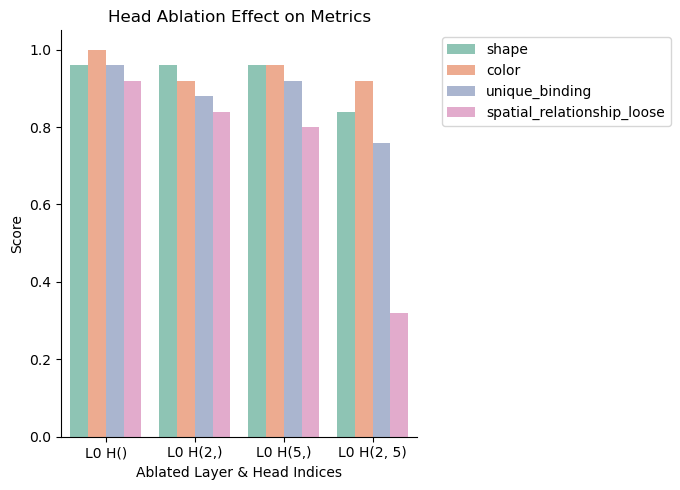

In [95]:
# Reset index so both ("target_layer", "target_head_indices") become columns
df_plot = head_ablation_summary.reset_index()

# Melt the dataframe so each metric is a row
# Exclude Dx, Dy, x1, y1, x2, y2 if you want, or keep only main metrics
# metrics = ["overall", "overall_loose", "shape", "color", "exist_binding", "unique_binding", "spatial_relationship", "spatial_relationship_loose"]
metrics = ["shape", "color", "unique_binding", "spatial_relationship_loose"]
df_melt = df_plot.melt(id_vars=["target_layer", "target_head_indices"], value_vars=metrics,
                       var_name="Metric", value_name="Value")

# Create a categorical x label for unique group
df_melt["HeadMask"] = df_melt.apply(
    lambda row: f"L{row['target_layer']} H{str(row['target_head_indices'])}", axis=1
)

plt.figure(figsize=(7, 5))
sns.barplot(
    data=df_melt,
    x="HeadMask",
    y="Value",
    hue="Metric",
    palette="Set2", alpha=0.8
)
plt.title("Head Ablation Effect on Metrics")
plt.ylabel("Score")
plt.xlabel("Ablated Layer & Head Indices")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
saveallforms(figdir, f"head_ablation_summary_L0H25_{prompt}_bars")
plt.show()

In [84]:
figroot

'/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/DiT_CLIP_attn_head_ablation_figures/DiT_mini'

### all prompt head ablation

In [96]:
from experimental_scripts.posthoc_generation_train_traj_eval_cli_cluster import generate_test_prompts_collection_and_parsed_words, mapping2spatial_relationship

In [97]:
from tqdm import tqdm
prompts, parsed_words = generate_test_prompts_collection_and_parsed_words()
prompt_df = pd.DataFrame(parsed_words)
prompt_df["relation_str"] = prompt_df["relation"].apply(lambda x: "_".join(x))
for prompt_id, row in tqdm(prompt_df.iterrows()):
    prompt = row["prompt"]
    scene_info = {
            "color1": row["color1"],
            "shape1": row["shape1"],
            "color2": row["color2"],
            "shape2": row["shape2"],
            "spatial_relationship": mapping2spatial_relationship[row["relation_str"]]
        }

96it [00:00, 40196.98it/s]


In [100]:
os.makedirs(join(figdir, "images_all_prompts"), exist_ok=True)

In [ ]:
all_prompt_head_ablation_results = []
all_prompt_head_ablation_synopses = []
for target_layer, target_head_indices in [(0, []), 
                                          (0, [2]), 
                                          (0, [5]), 
                                          (0, [2,5]), 
                                          ]:
    print("Layer: ", target_layer, "Heads: ", target_head_indices)
    # for prompt_i, (prompt, scene_info) in enumerate(zip(prompts, scene_infos)):
    for prompt_id, row in tqdm(prompt_df.iterrows()):
        prompt = row["prompt"]
        scene_info = {
                "color1": row["color1"],
                "shape1": row["shape1"],
                "color2": row["color2"],
                "shape2": row["shape2"],
                "spatial_relationship": mapping2spatial_relationship[row["relation_str"]]
        }
        output = visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, weight_dtype=torch.float16,
                                        num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, 
                                        device="cuda", random_seed=42, target_layer_idx=target_layer, target_head_indices=target_head_indices, 
                                        manipulated_mask_func=mask_all_attention, )
        # images_results.append(output[0]["images"])
        # display(pil_images_to_grid(output[0]["images"]))
        pil_images_to_grid(output[0]["images"]).\
            save(join(figdir, "images_all_prompts", f"head_ablation_L{target_layer}H{str(target_head_indices)}_prompt_{prompt_id}_{prompt}.png"))
        eval_df, object_df = evaluate_images(output[0]["images"], prompt, scene_info, color_margin=25, spatial_threshold=5)
        # display(print_evaluation_summary_concise(eval_df))
        # add labels
        eval_df = eval_df.assign(target_layer=target_layer,
                                target_head_indices=[tuple(target_head_indices)] * len(eval_df))
        eval_df["prompt_id"] = prompt_id
        all_prompt_head_ablation_results.append(eval_df)
        all_prompt_head_ablation_synopses.append(print_evaluation_summary_concise(eval_df, show=False))
    print("Done with layer ", target_layer, "Heads: ", target_head_indices)
    all_prompt_head_ablation_results_df = pd.concat(all_prompt_head_ablation_results)
    display(all_prompt_head_ablation_results_df.groupby(["target_layer", "target_head_indices"], sort=False).\
                mean(numeric_only=True).drop(columns=['prompt_id', 'sample_id'], errors='ignore').round(3))
all_prompt_head_ablation_results = pd.concat(all_prompt_head_ablation_results)

In [106]:
all_prompt_head_ablation_results.to_csv(join(figdir, f"all_prompt_head_ablation_results_L0H25.csv"), index=False)
all_prompt_head_ablation_results.to_pickle(join(figdir, f"all_prompt_head_ablation_results_L0H25.pkl"))
all_prompt_head_ablation_synopses_df = pd.concat(all_prompt_head_ablation_synopses)
all_prompt_head_ablation_synopses_df.to_csv(join(figdir, f"all_prompt_head_ablation_synopses_L0H25.csv"), index=False)
all_prompt_head_ablation_synopses_df.to_pickle(join(figdir, f"all_prompt_head_ablation_synopses_L0H25.pkl"))

In [101]:
display(all_prompt_head_ablation_results.groupby(["target_layer", "target_head_indices"], sort=False).\
                mean(numeric_only=True).drop(columns=['prompt_id', 'sample_id'], errors='ignore').round(3))
# all_prompt_head_ablation_results = pd.concat(all_prompt_head_ablation_results)

overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (2,)                   0.401          0.495  0.720  0.654   
             (5,)                   0.454          0.645  0.851  0.785   
             (2, 5)                 0.138          0.188  0.603  0.433   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (2,)                         0.574           0.573   
             (5,)                         0.736           0.735   
             (2, 5)                       0.358           0.355   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (2,)                                0.401   
             (5,)                                0.454   
             (2, 5)                              0.138   

                                  spatial_relationship_loose     Dx     Dy  \
target_layer target_head_indices                                             
0            ()                                        0.808  5.031  7.733   
             (2,)                                      0.495  4.387  3.742   
             (5,)                                      0.645  3.257  7.878   
             (2, 5)                                    0.188  0.406  3.462   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   70.585  68.974  65.554  61.241  
             (2,)                 72.954  69.626  68.568  65.884  
             (5,)                 66.939  68.485  63.682  60.607  
             (2, 5)               68.282  70.285  67.876  66.823

In [108]:
all_prompt_head_ablation_results = pd.read_pickle(join(figdir, f"all_prompt_head_ablation_results_L0H25.pkl"))

In [109]:
all_prompt_head_ablation_summary = all_prompt_head_ablation_results.groupby(["target_layer", "target_head_indices"], sort=False).\
                mean(numeric_only=True).drop(columns=['prompt_id', 'sample_id'], errors='ignore').round(3)

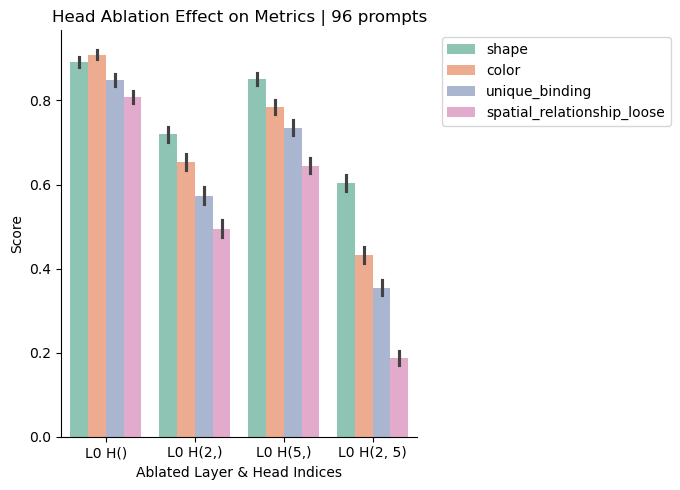

In [111]:
# Reset index so both ("target_layer", "target_head_indices") become columns
df_plot = all_prompt_head_ablation_results.reset_index()

# Melt the dataframe so each metric is a row
# Exclude Dx, Dy, x1, y1, x2, y2 if you want, or keep only main metrics
# metrics = ["overall", "overall_loose", "shape", "color", "exist_binding", "unique_binding", "spatial_relationship", "spatial_relationship_loose"]
metrics = ["shape", "color", "unique_binding", "spatial_relationship_loose"]
df_melt = df_plot.melt(id_vars=["target_layer", "target_head_indices"], value_vars=metrics,
                       var_name="Metric", value_name="Value")

# Create a categorical x label for unique group
df_melt["HeadMask"] = df_melt.apply(
    lambda row: f"L{row['target_layer']} H{str(row['target_head_indices'])}", axis=1
)

plt.figure(figsize=(7, 5))
sns.barplot(
    data=df_melt,
    x="HeadMask",
    y="Value",
    hue="Metric",
    palette="Set2", alpha=0.8
)
plt.title("Head Ablation Effect on Metrics | 96 prompts")
plt.ylabel("Score")
plt.xlabel("Ablated Layer & Head Indices")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
saveallforms(figdir, f"head_ablation_summary_L0H25_all_prompts_bars")
plt.show()

### All prompts no generalization

In [130]:
def generate_test_prompts_collection_and_parsed_words_no_generalization():
    """Generate test prompts for evaluation."""
    from itertools import product
    
    colors = ['red', 'blue']
    target_shapes = ['square', 'triangle', 'circle']
    verticals = ['above', 'below']
    horizontals = ['to the left of', 'to the right of']
    prompts = []
    parsed_words = []
    for c1, c2 in product(colors, colors):
        if c1 == c2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(target_shapes, target_shapes):
            if shape1 == shape2:
                continue
            for v in verticals:
                prompts.append(f"{c1} {shape1} is {v} {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [v], "color2": c2, "shape2": shape2, "prop": ["is", "the"], "prompt": prompts[-1]})
            for h in horizontals:
                prompts.append(f"{c1} {shape1} is {h} {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [h.split(" ")[2]], "color2": c2, "shape2": shape2, "prop": ["is", "the", "to", "of"], "prompt": prompts[-1]})
            for v, h in product(verticals, horizontals):
                prompts.append(f"{c1} {shape1} is {v} and {h} {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [v, h.split(" ")[2]], "color2": c2, "shape2": shape2, "prop": ["is", "the", "to", "of", "and"], "prompt": prompts[-1]})
    return prompts, parsed_words

In [131]:
prompts, parsed_words = generate_test_prompts_collection_and_parsed_words_no_generalization()
prompt_df_no_gen = pd.DataFrame(parsed_words)
prompt_df_no_gen["relation_str"] = prompt_df_no_gen["relation"].apply(lambda x: "_".join(x))

In [132]:
import contextlib
import io
f = io.StringIO()

all_prompt_no_gen_head_ablation_results = []
for target_layer, target_head_indices in [(0, []), 
                                          (0, [2]), 
                                          (0, [5]), 
                                          (0, [2,5]), 
                                          ]:
    print("Layer: ", target_layer, "Heads: ", target_head_indices)
    # for prompt_i, (prompt, scene_info) in enumerate(zip(prompts, scene_infos)):
    for prompt_id, row in tqdm(prompt_df_no_gen.iterrows()):
        prompt = row["prompt"]
        scene_info = {
                "color1": row["color1"],
                "shape1": row["shape1"],
                "color2": row["color2"],
                "shape2": row["shape2"],
                "spatial_relationship": mapping2spatial_relationship[row["relation_str"]]
        }
        
        with contextlib.redirect_stdout(f):
            output = visualize_prompt_with_head_masking(pipeline, prompt, max_length=20, weight_dtype=torch.float16,
                                        num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, 
                                        device="cuda", random_seed=42, target_layer_idx=target_layer, target_head_indices=target_head_indices, 
                                        manipulated_mask_func=mask_all_attention, )

        pil_images_to_grid(output[0]["images"]).\
            save(join(figdir, "images_all_prompts", f"head_ablation_L{target_layer}H{str(target_head_indices)}_prompt_{prompt_id}_{prompt}.png"))
        eval_df, object_df = evaluate_images(output[0]["images"], prompt, scene_info, color_margin=25, spatial_threshold=5)
        eval_df = eval_df.assign(target_layer=target_layer,
                                target_head_indices=[tuple(target_head_indices)] * len(eval_df))
        eval_df["prompt_id"] = prompt_id
        all_prompt_no_gen_head_ablation_results.append(eval_df)
    print("Done with layer ", target_layer, "Heads: ", target_head_indices)
    all_prompt_no_gen_head_ablation_results_df = pd.concat(all_prompt_no_gen_head_ablation_results)
    display(all_prompt_no_gen_head_ablation_results_df.groupby(["target_layer", "target_head_indices"], sort=False).\
                mean(numeric_only=True).drop(columns=['prompt_id', 'sample_id'], errors='ignore').round(3))


Layer:  0 Heads:  []


96it [01:01,  1.55it/s]

Done with layer  0 Heads:  []


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.634           0.82  0.869  0.888   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.835           0.834   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.634   

                                  spatial_relationship_loose     Dx     Dy  \
target_layer target_head_indices                                             
0            ()                                         0.82  0.215  0.066   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   67.286  65.212  67.071  65.146

Layer:  0 Heads:  [2]


96it [01:03,  1.52it/s]

Done with layer  0 Heads:  [2]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.634          0.820  0.869  0.888   
             (2,)                   0.422          0.498  0.698  0.629   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.835           0.834   
             (2,)                         0.551           0.550   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.634   
             (2,)                                0.422   

                                  spatial_relationship_loose     Dx     Dy  \
target_layer target_head_indices                                             
0            ()                                        0.820  0.215  0.066   
             (2,)                                      0.498 -0.934 -2.851   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   67.286  65.212  67.071  65.146  
             (2,)                 69.069  66.256  70.003  69.107

Layer:  0 Heads:  [5]


96it [01:05,  1.47it/s]

Done with layer  0 Heads:  [5]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.634          0.820  0.869  0.888   
             (2,)                   0.422          0.498  0.698  0.629   
             (5,)                   0.494          0.657  0.835  0.758   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.835           0.834   
             (2,)                         0.551           0.550   
             (5,)                         0.709           0.708   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.634   
             (2,)                                0.422   
             (5,)                                0.494   

                                  spatial_relationship_loose     Dx     Dy  \
target_layer target_head_indices                                             
0            ()                                        0.820  0.215  0.066   
             (2,)                                      0.498 -0.934 -2.851   
             (5,)                                      0.657 -0.919  1.093   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   67.286  65.212  67.071  65.146  
             (2,)                 69.069  66.256  70.003  69.107  
             (5,)                 65.182  65.182  66.101  64.089

Layer:  0 Heads:  [2, 5]


96it [01:04,  1.48it/s]

Done with layer  0 Heads:  [2, 5]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.634          0.820  0.869  0.888   
             (2,)                   0.422          0.498  0.698  0.629   
             (5,)                   0.494          0.657  0.835  0.758   
             (2, 5)                 0.148          0.177  0.554  0.388   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.835           0.834   
             (2,)                         0.551           0.550   
             (5,)                         0.709           0.708   
             (2, 5)                       0.318           0.317   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.634   
             (2,)                                0.422   
             (5,)                                0.494   
             (2, 5)                              0.148   

                                  spatial_relationship_loose     Dx     Dy  \
target_layer target_head_indices                                             
0            ()                                        0.820  0.215  0.066   
             (2,)                                      0.498 -0.934 -2.851   
             (5,)                                      0.657 -0.919  1.093   
             (2, 5)                                    0.177 -1.855 -1.254   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   67.286  65.212  67.071  65.146  
             (2,)                 69.069  66.256  70.003  69.107  
             (5,)                 65.182  65.182  66.101  64.089  
             (2, 5)               67.188  66.657  69.043  67.911

In [133]:
all_prompt_no_gen_head_ablation_results = pd.concat(all_prompt_no_gen_head_ablation_results)
all_prompt_no_gen_head_ablation_results.to_csv(join(figdir, f"all_prompt_no_gen_head_ablation_results_L0H25.csv"), index=False)
all_prompt_no_gen_head_ablation_results.to_pickle(join(figdir, f"all_prompt_no_gen_head_ablation_results_L0H25.pkl"))

In [135]:
display(all_prompt_no_gen_head_ablation_results.groupby(["target_layer", "target_head_indices"], sort=False).\
                mean(numeric_only=True).drop(columns=['prompt_id', 'sample_id'], errors='ignore').round(3))
# all_prompt_head_ablation_results = pd.concat(all_prompt_head_ablation_results)

overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.634          0.820  0.869  0.888   
             (2,)                   0.422          0.498  0.698  0.629   
             (5,)                   0.494          0.657  0.835  0.758   
             (2, 5)                 0.148          0.177  0.554  0.388   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.835           0.834   
             (2,)                         0.551           0.550   
             (5,)                         0.709           0.708   
             (2, 5)                       0.318           0.317   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.634   
             (2,)                                0.422   
             (5,)                                0.494   
             (2, 5)                              0.148   

                                  spatial_relationship_loose     Dx     Dy  \
target_layer target_head_indices                                             
0            ()                                        0.820  0.215  0.066   
             (2,)                                      0.498 -0.934 -2.851   
             (5,)                                      0.657 -0.919  1.093   
             (2, 5)                                    0.177 -1.855 -1.254   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   67.286  65.212  67.071  65.146  
             (2,)                 69.069  66.256  70.003  69.107  
             (5,)                 65.182  65.182  66.101  64.089  
             (2, 5)               67.188  66.657  69.043  67.911

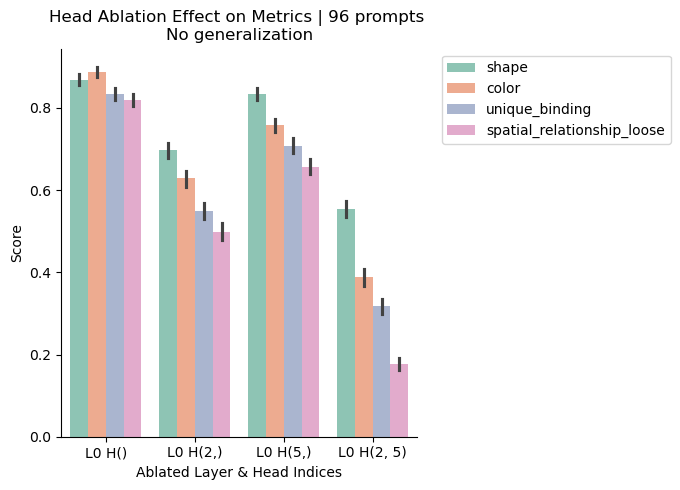

In [138]:
# Reset index so both ("target_layer", "target_head_indices") become columns
df_plot = all_prompt_no_gen_head_ablation_results.reset_index()

# Melt the dataframe so each metric is a row
# Exclude Dx, Dy, x1, y1, x2, y2 if you want, or keep only main metrics
# metrics = ["overall", "overall_loose", "shape", "color", "exist_binding", "unique_binding", "spatial_relationship", "spatial_relationship_loose"]
metrics = ["shape", "color", "unique_binding", "spatial_relationship_loose"]
df_melt = df_plot.melt(id_vars=["target_layer", "target_head_indices"], value_vars=metrics,
                       var_name="Metric", value_name="Value")

# Create a categorical x label for unique group
df_melt["HeadMask"] = df_melt.apply(
    lambda row: f"L{row['target_layer']} H{str(row['target_head_indices'])}", axis=1
)

plt.figure(figsize=(7, 5))
sns.barplot(
    data=df_melt,
    x="HeadMask",
    y="Value",
    hue="Metric",
    palette="Set2", alpha=0.8
)
plt.title("Head Ablation Effect on Metrics | 96 prompts \nNo generalization")
plt.ylabel("Score")
plt.xlabel("Ablated Layer & Head Indices")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
saveallforms(figdir, f"head_ablation_summary_L0H25_all_prompts_no_gen_bars")
plt.show()

Generalization (the blue circle) and no generalization (no the) has similar structure

### All heads filtering 

In [114]:
figstoredir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/analysis_results/objrel_CLIPemb_DiT_mini_pilot/cross_attn_head_ablation_results/images_all_prompts"
os.makedirs(figstoredir, exist_ok=True)

In [122]:
from itertools import product
# Suppress stdout (prints) during visualize_prompt_with_head_masking
import contextlib
import io
f = io.StringIO()

all_prompt_all_heads_ablation_results = []
all_prompt_all_heads_ablation_object_results = []
for target_layer, target_head_indices in [(0, []),
                                          *product(range(6), [[i] for i in range(6)])]:
        print("Layer: ", target_layer, "Heads: ", target_head_indices)
        # for prompt_i, (prompt, scene_info) in enumerate(zip(prompts, scene_infos)):
        for prompt_id, row in tqdm(prompt_df.iterrows()):
            prompt = row["prompt"]
            scene_info = {
                    "color1": row["color1"],
                    "shape1": row["shape1"],
                    "color2": row["color2"],
                    "shape2": row["shape2"],
                    "spatial_relationship": mapping2spatial_relationship[row["relation_str"]]
            }
            
            with contextlib.redirect_stdout(f):
                output = visualize_prompt_with_head_masking(
                    pipeline, prompt, max_length=20, weight_dtype=torch.float16,
                    num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, 
                    device="cuda", random_seed=42, target_layer_idx=target_layer, target_head_indices=target_head_indices, 
                    manipulated_mask_func=mask_all_attention,
                )
            # images_results.append(output[0]["images"])
            # display(pil_images_to_grid(output[0]["images"]))
            pil_images_to_grid(output[0]["images"]).\
                save(join(figstoredir, f"head_ablation_L{target_layer}H{str(target_head_indices)}_prompt_{prompt_id}_{prompt}.png"))
            eval_df, object_df = evaluate_images(output[0]["images"], prompt, scene_info, color_margin=25, spatial_threshold=5)
            # display(print_evaluation_summary_concise(eval_df))
            # add labels
            object_df = object_df.assign(target_layer=target_layer,
                                    target_head_indices=[tuple(target_head_indices)] * len(object_df))
            object_df["prompt_id"] = prompt_id
            eval_df = eval_df.assign(target_layer=target_layer,
                                    target_head_indices=[tuple(target_head_indices)] * len(eval_df))
            eval_df["prompt_id"] = prompt_id
            all_prompt_all_heads_ablation_results.append(eval_df)
            all_prompt_all_heads_ablation_object_results.append(object_df)
            # all_prompt_all_heads_ablation_synopses.append(print_evaluation_summary_concise(eval_df, show=False))
        print("Done with layer ", target_layer, "Heads: ", target_head_indices)
        all_prompt_head_ablation_results_df = pd.concat(all_prompt_all_heads_ablation_results)
        display(all_prompt_head_ablation_results_df.groupby(["target_layer", "target_head_indices"], sort=False).\
                    mean(numeric_only=True).drop(columns=['prompt_id', 'sample_id'], errors='ignore').round(3))
all_prompt_head_ablation_results = pd.concat(all_prompt_all_heads_ablation_results)
all_prompt_head_ablation_results.to_csv(join(figdir, f"all_prompt_head_ablation_results_all_heads.csv"), index=False)
all_prompt_head_ablation_results.to_pickle(join(figdir, f"all_prompt_head_ablation_results_all_heads.pkl"))
all_prompt_all_heads_ablation_object_results = pd.concat(all_prompt_all_heads_ablation_object_results)
all_prompt_all_heads_ablation_object_results.to_csv(join(figdir, f"all_prompt_all_heads_ablation_object_results.csv"), index=False)
all_prompt_all_heads_ablation_object_results.to_pickle(join(figdir, f"all_prompt_all_heads_ablation_object_results.pkl"))


Layer:  0 Heads:  []


0it [00:00, ?it/s]

96it [00:59,  1.61it/s]

Done with layer  0 Heads:  []


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   

                                  spatial_relationship_loose     Dx     Dy  \
target_layer target_head_indices                                             
0            ()                                        0.808  5.031  7.733   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   70.585  68.974  65.554  61.241

Layer:  0 Heads:  [0]


96it [01:02,  1.54it/s]

Done with layer  0 Heads:  [0]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   

                                  spatial_relationship_loose     Dx     Dy  \
target_layer target_head_indices                                             
0            ()                                        0.808  5.031  7.733   
             (0,)                                      0.696  5.571  7.742   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   70.585  68.974  65.554  61.241  
             (0,)                 71.344  69.480  65.774  61.738

Layer:  0 Heads:  [1]


96it [01:02,  1.52it/s]

Done with layer  0 Heads:  [1]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   70.585  68.974  65.554  61.241  
             (0,)                 71.344  69.480  65.774  61.738  
             (1,)                 69.468  70.956  64.156  60.881

Layer:  0 Heads:  [2]


96it [01:01,  1.56it/s]

Done with layer  0 Heads:  [2]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                      0.495  4.387   3.742   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   70.585  68.974  65.554  61.241  
             (0,)                 71.344  69.480  65.774  61.738  
             (1,)                 69.468  70.956  64.156  60.881  
             (2,)                 72.954  69.626  68.568  65.884

Layer:  0 Heads:  [3]


96it [01:02,  1.54it/s]

Done with layer  0 Heads:  [3]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                      0.495  4.387   3.742   
             (3,)                                      0.677  6.844   9.071   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   70.585  68.974  65.554  61.241  
             (0,)                 71.344  69.480  65.774  61.738  
             (1,)                 69.468  70.956  64.156  60.881  
             (2,)                 72.954  69.626  68.568  65.884  
             (3,)                 68.858  69.836  62.014  60.766

Layer:  0 Heads:  [4]


96it [01:02,  1.53it/s]

Done with layer  0 Heads:  [4]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                      0.495  4.387   3.742   
             (3,)                                      0.677  6.844   9.071   
             (4,)                                      0.725  5.641   5.397   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   70.585  68.974  65.554  61.241  
             (0,)                 71.344  69.480  65.774  61.738  
             (1,)                 69.468  70.956  64.156  60.881  
             (2,)                 72.954  69.626  68.568  65.884  
             (3,)                 68.858  69.836  62.014  60.766  
             (4,)                 70.118  67.851  64.477  62.454

Layer:  0 Heads:  [5]


96it [01:02,  1.55it/s]

Done with layer  0 Heads:  [5]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                      0.495  4.387   3.742   
             (3,)                                      0.677  6.844   9.071   
             (4,)                                      0.725  5.641   5.397   
             (5,)                                      0.645  3.257   7.878   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   70.585  68.974  65.554  61.241  
             (0,)                 71.344  69.480  65.774  61.738  
             (1,)                 69.468  70.956  64.156  60.881  
             (2,)                 72.954  69.626  68.568  65.884  
             (3,)                 68.858  69.836  62.014  60.766  
             (4,)                 70.118  67.851  64.477  62.454  
             (5,)                 66.939  68.485  63.682  60.607

Layer:  1 Heads:  [0]


96it [01:03,  1.50it/s]

Done with layer  1 Heads:  [0]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                      0.495  4.387   3.742   
             (3,)                                      0.677  6.844   9.071   
             (4,)                                      0.725  5.641   5.397   
             (5,)                                      0.645  3.257   7.878   
1            (0,)                                      0.620  5.250   9.330   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   70.585  68.974  65.554  61.241  
             (0,)                 71.344  69.480  65.774  61.738  
             (1,)                 69.468  70.956  64.156  60.881  
             (2,)                 72.954  69.626  68.568  65.884  
             (3,)                 68.858  69.836  62.014  60.766  
             (4,)                 70.118  67.851  64.477  62.454  
             (5,)                 66.939  68.485  63.682  60.607  
1            (0,)                 71.455  70.028  66.204  60.698

Layer:  1 Heads:  [1]


96it [01:03,  1.52it/s]

Done with layer  1 Heads:  [1]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                      0.495  4.387   3.742   
             (3,)                                      0.677  6.844   9.071   
             (4,)                                      0.725  5.641   5.397   
             (5,)                                      0.645  3.257   7.878   
1            (0,)                                      0.620  5.250   9.330   
             (1,)                                      0.706  7.681   8.384   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   70.585  68.974  65.554  61.241  
             (0,)                 71.344  69.480  65.774  61.738  
             (1,)                 69.468  70.956  64.156  60.881  
             (2,)                 72.954  69.626  68.568  65.884  
             (3,)                 68.858  69.836  62.014  60.766  
             (4,)                 70.118  67.851  64.477  62.454  
             (5,)                 66.939  68.485  63.682  60.607  
1            (0,)                 71.455  70.028  66.204  60.698  
             (1,)                 69.904  68.654  62.223  60.270

Layer:  1 Heads:  [2]


96it [01:02,  1.53it/s]


Done with layer  1 Heads:  [2]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
             (2,)                                0.462   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                      0.495  4.387   3.742   
             (3,)                                      0.677  6.844   9.071   
             (4,)                                      0.725  5.641   5.397   
             (5,)                                      0.645  3.257   7.878   
1            (0,)                                      0.620  5.250   9.330   
             (1,)                                      0.706  7.681   8.384   
             (2,)                                      0.622  6.189  10.186   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   70.585  68.974  65.554  61.241  
             (0,)                 71.344  69.480  65.774  61.738  
             (1,)                 69.468  70.956  64.156  60.881  
             (2,)                 72.954  69.626  68.568  65.884  
             (3,)                 68.858  69.836  62.014  60.766  
             (4,)                 70.118  67.851  64.477  62.454  
             (5,)                 66.939  68.485  63.682  60.607  
1            (0,)                 71.455  70.028  66.204  60.698  
             (1,)       

Layer:  1 Heads:  [3]


96it [01:02,  1.53it/s]

Done with layer  1 Heads:  [3]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
             (2,)                                0.462   
             (3,)                                0.380   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                      0.495  4.387   3.742   
             (3,)                                      0.677  6.844   9.071   
             (4,)                                      0.725  5.641   5.397   
             (5,)                                      0.645  3.257   7.878   
1            (0,)                                      0.620  5.250   9.330   
             (1,)                                      0.706  7.681   8.384   
             (2,)                                      0.622  6.189  10.186   
             (3,)                                      0.559  2.749   7.496   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0            ()                   70.585  68.974  65.554  61.241  
             (0,)                 71.344  69.480  65.774  61.738  
             (1,)                 69.468  70.956  64.156  60.881  
             (2,)                 72.954  69.626  68.568  65.884  
             (

Layer:  1 Heads:  [4]


96it [01:02,  1.53it/s]

Done with layer  1 Heads:  [4]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
             (2,)                                0.462   
             (3,)                                0.380   
             (4,)                                0.495   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                      0.495  4.387   3.742   
             (3,)                                      0.677  6.844   9.071   
             (4,)                                      0.725  5.641   5.397   
             (5,)                                      0.645  3.257   7.878   
1            (0,)                                      0.620  5.250   9.330   
             (1,)                                      0.706  7.681   8.384   
             (2,)                                      0.622  6.189  10.186   
             (3,)                                      0.559  2.749   7.496   
             (4,)                                      0.680  6.225   9.077   

                                      x1      y1      x2      y2  
target_layer target_head_indices                                  
0   

Layer:  1 Heads:  [5]


96it [01:03,  1.52it/s]

Done with layer  1 Heads:  [5]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
             (2,)                                0.462   
             (3,)                                0.380   
             (4,)                                0.495   
             (5,)                                0.486   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                      0.495  4.387   3.742   
             (3,)                                      0.677  6.844   9.071   
             (4,)                                      0.725  5.641   5.397   
             (5,)                                      0.645  3.257   7.878   
1            (0,)                                      0.620  5.250   9.330   
             (1,)                                      0.706  7.681   8.384   
             (2,)                                      0.622  6.189  10.186   
             (3,)                                      0.559  2.749   7.496   
             (4,)  

Layer:  2 Heads:  [0]


96it [01:02,  1.53it/s]


Done with layer  2 Heads:  [0]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
             (2,)                                0.462   
             (3,)                                0.380   
             (4,)                                0.495   
             (5,)                                0.486   
2            (0,)                                0.207   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                      0.495  4.387   3.742   
             (3,)                                      0.677  6.844   9.071   
             (4,)                                      0.725  5.641   5.397   
             (5,)                                      0.645  3.257   7.878   
1            (0,)                                      0.620  5.250   9.330   
             (1,)                                      0.

Layer:  2 Heads:  [1]


96it [01:03,  1.52it/s]


Done with layer  2 Heads:  [1]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
             (2,)                                0.462   
             (3,)                                0.380   
             (4,)                                0.495   
             (5,)                                0.486   
2            (0,)                                0.207   
             (1,)                                0.363   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                      0.495  4.387   3.742   
             (3,)                                      0.677  6.844   9.071   
             (4,)                                      0.725  5.641   5.397   
             (5,

Layer:  2 Heads:  [2]


96it [01:02,  1.54it/s]


Done with layer  2 Heads:  [2]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
             (2,)                                0.462   
             (3,)                                0.380   
             (4,)                                0.495   
             (5,)                                0.486   
2            (0,)                                0.207   
             (1,)                                0.363   
             (2,)                                0.322   

                                  spatial_relationship_loose     Dx      Dy  \
target_layer target_head_indices                                              
0            ()                                        0.808  5.031   7.733   
             (0,)                                      0.696  5.571   7.742   
             (1,)                                      0.691  5.312  10.074   
             (2,)                                     

Layer:  2 Heads:  [3]


96it [01:02,  1.53it/s]


Done with layer  2 Heads:  [3]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
             (2,)                                0.462   
             (3,)                                0.380   
             (4,)                                0.495   
             (5,)                                0.486   
2            (0,)                                0.207   
             (1,)                                0.363   
             (2,)                                0.322   
             (3,)                                0.289   

                                  spatial_relationship_loose      Dx      Dy  \
target_layer target_head_indices                                               
0            ()                                        0.808   5.031   7.733   
          

Layer:  2 Heads:  [4]


96it [01:04,  1.49it/s]


Done with layer  2 Heads:  [4]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
             (2,)                                0.462   
             (3,)                                0.380   
             (4,)                                0.495   
             (5,)                                0.486   
2            (0,)                                0.207   
             (1,)                                0.363   
             (2,)                                0.322   
             (3,)                                0.289   
             (4,)                                0.396   

                                  spatial_relations

Layer:  2 Heads:  [5]


96it [01:01,  1.56it/s]


Done with layer  2 Heads:  [5]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
             (2,)                                0.462   
             (3,)                                0.380   
             (4,)                                0.495   
             (5,)                                0.486   
2            (0,)                                0.207   
             (1,)                                0.363   
             (2,)                                0.322   
             (3,)          

Layer:  3 Heads:  [0]


96it [01:03,  1.51it/s]


Done with layer  3 Heads:  [0]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
             (2,)                                0.462   
             (3,)                                0.380   
             (4,)                                0.495   
             (5,)                                0.486   
2            (0,)                                0.207   
  

Layer:  3 Heads:  [1]


96it [01:03,  1.50it/s]


Done with layer  3 Heads:  [1]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   
             (1,)                         0.319           0.319   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
             (2,)                                0.462   
             (3,)                                0.380   
             (4,)                  

Layer:  3 Heads:  [2]


96it [01:04,  1.49it/s]


Done with layer  3 Heads:  [2]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   
             (1,)                         0.319           0.319   
             (2,)                         0.544           0.544   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                                0.454   
1            (0,)                                0.464   
             (1,)                                0.518   
          

Layer:  3 Heads:  [3]


96it [01:04,  1.49it/s]


Done with layer  3 Heads:  [3]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   
             (1,)                         0.319           0.319   
             (2,)                         0.544           0.544   
             (3,)                         0.682           0.682   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,)                                0.502   
             (4,)                                0.530   
             (5,)                          

Layer:  3 Heads:  [4]


96it [01:02,  1.53it/s]


Done with layer  3 Heads:  [4]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   
             (1,)                         0.319           0.319   
             (2,)                         0.544           0.544   
             (3,)                         0.682           0.682   
             (4,)                         0.579           0.578   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.510   
             (1,)                                0.487   
             (2,)                                0.401   
             (3,) 

Layer:  3 Heads:  [5]


96it [01:05,  1.48it/s]


Done with layer  3 Heads:  [5]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   
             (1,)                         0.319           0.319   
             (2,)                         0.544           0.544   
             (3,)                         0.682           0.682   
             (4,)                         0.579           0.578   
             (5,)                         0.512           0.509   

                                  spatial_relationship  \
target_layer target_head_indices                         
0            ()                                  0.587   
             (0,)                                0.

Layer:  4 Heads:  [0]


96it [01:04,  1.48it/s]


Done with layer  4 Heads:  [0]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   
             (1,)                         0.319           0.319   
             (2,)                         0.544           0.544   
             (3,)                         0.682           0.682   
             (4,)                         0.579           0.578   
             (5,)                         0.512           0.509   
4            (0,)                         0.531           0.530   

                                  spatial_relationship  \
target_layer target_head_i

Layer:  4 Heads:  [1]


96it [01:05,  1.47it/s]


Done with layer  4 Heads:  [1]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   
             (1,)                   0.256          0.351  0.838  0.410   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   
             (1,)                         0.319           0.319   
             (2,)                         0.544           0.544   
             (3,)                         0.682           0.682   
             (4,)                         0.579           0.578   
             (5,)                         0.512           0.509   
4            (0,)                         0.531           0.530   
           

Layer:  4 Heads:  [2]


96it [01:03,  1.50it/s]


Done with layer  4 Heads:  [2]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   
             (1,)                   0.256          0.351  0.838  0.410   
             (2,)                   0.298          0.400  0.827  0.457   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   
             (1,)                         0.319           0.319   
             (2,)                         0.544           0.544   
             (3,)                         0.682           0.682   
             (4,)                         0.579           0.578   
             (5,)                         0.512           0.509   
4   

Layer:  4 Heads:  [3]


96it [01:05,  1.47it/s]


Done with layer  4 Heads:  [3]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   
             (1,)                   0.256          0.351  0.838  0.410   
             (2,)                   0.298          0.400  0.827  0.457   
             (3,)                   0.408          0.551  0.855  0.616   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   
             (1,)                         0.319           0.319   
             (2,)                         0.544           0.544   
             (3,)                         0.682           0.682   
             (4,)                         0.579           0.578 

Layer:  4 Heads:  [4]


96it [01:04,  1.50it/s]


Done with layer  4 Heads:  [4]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   
             (1,)                   0.256          0.351  0.838  0.410   
             (2,)                   0.298          0.400  0.827  0.457   
             (3,)                   0.408          0.551  0.855  0.616   
             (4,)                   0.552          0.759  0.876  0.849   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   
             (1,)                         0.319           0.319   
             (2,)                         0.544           0.544   
             (3,)                         0.682          

Layer:  4 Heads:  [5]


96it [01:04,  1.50it/s]


Done with layer  4 Heads:  [5]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   
             (1,)                   0.256          0.351  0.838  0.410   
             (2,)                   0.298          0.400  0.827  0.457   
             (3,)                   0.408          0.551  0.855  0.616   
             (4,)                   0.552          0.759  0.876  0.849   
             (5,)                   0.313          0.441  0.832  0.482   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   
             (1,)                         0.319           0.319   
             (2,)                         0.544   

Layer:  5 Heads:  [0]


96it [01:04,  1.49it/s]


Done with layer  5 Heads:  [0]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   
             (1,)                   0.256          0.351  0.838  0.410   
             (2,)                   0.298          0.400  0.827  0.457   
             (3,)                   0.408          0.551  0.855  0.616   
             (4,)                   0.552          0.759  0.876  0.849   
             (5,)                   0.313          0.441  0.832  0.482   
5            (0,)                   0.445          0.636  0.861  0.735   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                         0.612           0.611   
             (1,)                         0

Layer:  5 Heads:  [1]


96it [01:01,  1.56it/s]


Done with layer  5 Heads:  [1]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   
             (1,)                   0.256          0.351  0.838  0.410   
             (2,)                   0.298          0.400  0.827  0.457   
             (3,)                   0.408          0.551  0.855  0.616   
             (4,)                   0.552          0.759  0.876  0.849   
             (5,)                   0.313          0.441  0.832  0.482   
5            (0,)                   0.445          0.636  0.861  0.735   
             (1,)                   0.587          0.821  0.896  0.923   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)                         0.805           0.805   
3            (0,)                   

Layer:  5 Heads:  [2]


96it [01:04,  1.50it/s]


Done with layer  5 Heads:  [2]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   
             (1,)                   0.256          0.351  0.838  0.410   
             (2,)                   0.298          0.400  0.827  0.457   
             (3,)                   0.408          0.551  0.855  0.616   
             (4,)                   0.552          0.759  0.876  0.849   
             (5,)                   0.313          0.441  0.832  0.482   
5            (0,)                   0.445          0.636  0.861  0.735   
             (1,)                   0.587          0.821  0.896  0.923   
             (2,)                   0.315          0.471  0.835  0.550   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)                         0.552           0.551   
             (5,)            

Layer:  5 Heads:  [3]


96it [01:04,  1.48it/s]


Done with layer  5 Heads:  [3]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   
             (1,)                   0.256          0.351  0.838  0.410   
             (2,)                   0.298          0.400  0.827  0.457   
             (3,)                   0.408          0.551  0.855  0.616   
             (4,)                   0.552          0.759  0.876  0.849   
             (5,)                   0.313          0.441  0.832  0.482   
5            (0,)                   0.445          0.636  0.861  0.735   
             (1,)                   0.587          0.821  0.896  0.923   
             (2,)                   0.315          0.471  0.835  0.550   
             (3,)                   0.366          0.522  0.848  0.595   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3,)                         0.423           0.422   
             (4,)     

Layer:  5 Heads:  [4]


96it [01:05,  1.46it/s]


Done with layer  5 Heads:  [4]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   
             (1,)                   0.256          0.351  0.838  0.410   
             (2,)                   0.298          0.400  0.827  0.457   
             (3,)                   0.408          0.551  0.855  0.616   
             (4,)                   0.552          0.759  0.876  0.849   
             (5,)                   0.313          0.441  0.832  0.482   
5            (0,)                   0.445          0.636  0.861  0.735   
             (1,)                   0.587          0.821  0.896  0.923   
             (2,)                   0.315          0.471  0.835  0.550   
             (3,)                   0.366          0.522  0.848  0.595   
             (4,)                   0.445          0.625  0.799  0.756   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
             (2,)                         0.482           0.482   
             (3

Layer:  5 Heads:  [5]


96it [01:04,  1.50it/s]


Done with layer  5 Heads:  [5]


overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   
             (1,)                   0.256          0.351  0.838  0.410   
             (2,)                   0.298          0.400  0.827  0.457   
             (3,)                   0.408          0.551  0.855  0.616   
             (4,)                   0.552          0.759  0.876  0.849   
             (5,)                   0.313          0.441  0.832  0.482   
5            (0,)                   0.445          0.636  0.861  0.735   
             (1,)                   0.587          0.821  0.896  0.923   
             (2,)                   0.315          0.471  0.835  0.550   
             (3,)                   0.366          0.522  0.848  0.595   
             (4,)                   0.445          0.625  0.799  0.756   
             (5,)                   0.509          0.698  0.842  0.820   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
        

In [123]:
all_prompt_head_ablation_results_df.groupby(["target_layer", "target_head_indices"], sort=False).\
                    mean(numeric_only=True).drop(columns=['prompt_id', 'sample_id'], errors='ignore').round(3)

overall  overall_loose  shape  color  \
target_layer target_head_indices                                         
0            ()                     0.587          0.808  0.891  0.909   
             (0,)                   0.510          0.696  0.802  0.846   
             (1,)                   0.487          0.691  0.846  0.798   
             (2,)                   0.401          0.495  0.720  0.654   
             (3,)                   0.502          0.677  0.839  0.768   
             (4,)                   0.530          0.725  0.868  0.818   
             (5,)                   0.454          0.645  0.851  0.785   
1            (0,)                   0.464          0.620  0.805  0.739   
             (1,)                   0.518          0.706  0.819  0.834   
             (2,)                   0.462          0.622  0.792  0.738   
             (3,)                   0.380          0.559  0.873  0.623   
             (4,)                   0.495          0.680  0.818  0.803   
             (5,)                   0.486          0.652  0.810  0.753   
2            (0,)                   0.207          0.301  0.458  0.468   
             (1,)                   0.363          0.512  0.818  0.587   
             (2,)                   0.322          0.463  0.810  0.535   
             (3,)                   0.289          0.405  0.616  0.542   
             (4,)                   0.396          0.519  0.800  0.614   
             (5,)                   0.567          0.763  0.863  0.854   
3            (0,)                   0.422          0.578  0.840  0.655   
             (1,)                   0.208          0.307  0.778  0.352   
             (2,)                   0.373          0.523  0.788  0.635   
             (3,)                   0.459          0.642  0.833  0.747   
             (4,)                   0.409          0.550  0.812  0.625   
             (5,)                   0.368          0.477  0.795  0.568   
4            (0,)                   0.359          0.507  0.849  0.563   
             (1,)                   0.256          0.351  0.838  0.410   
             (2,)                   0.298          0.400  0.827  0.457   
             (3,)                   0.408          0.551  0.855  0.616   
             (4,)                   0.552          0.759  0.876  0.849   
             (5,)                   0.313          0.441  0.832  0.482   
5            (0,)                   0.445          0.636  0.861  0.735   
             (1,)                   0.587          0.821  0.896  0.923   
             (2,)                   0.315          0.471  0.835  0.550   
             (3,)                   0.366          0.522  0.848  0.595   
             (4,)                   0.445          0.625  0.799  0.756   
             (5,)                   0.509          0.698  0.842  0.820   

                                  exist_binding  unique_binding  \
target_layer target_head_indices                                  
0            ()                           0.849           0.849   
             (0,)                         0.735           0.732   
             (1,)                         0.731           0.730   
             (2,)                         0.574           0.573   
             (3,)                         0.720           0.720   
             (4,)                         0.766           0.766   
             (5,)                         0.736           0.735   
1            (0,)                         0.660           0.659   
             (1,)                         0.745           0.745   
             (2,)                         0.667           0.667   
             (3,)                         0.583           0.582   
             (4,)                         0.720           0.720   
             (5,)                         0.692           0.691   
2            (0,)                         0.316           0.316   
             (1,)                         0.535           0.535   
        

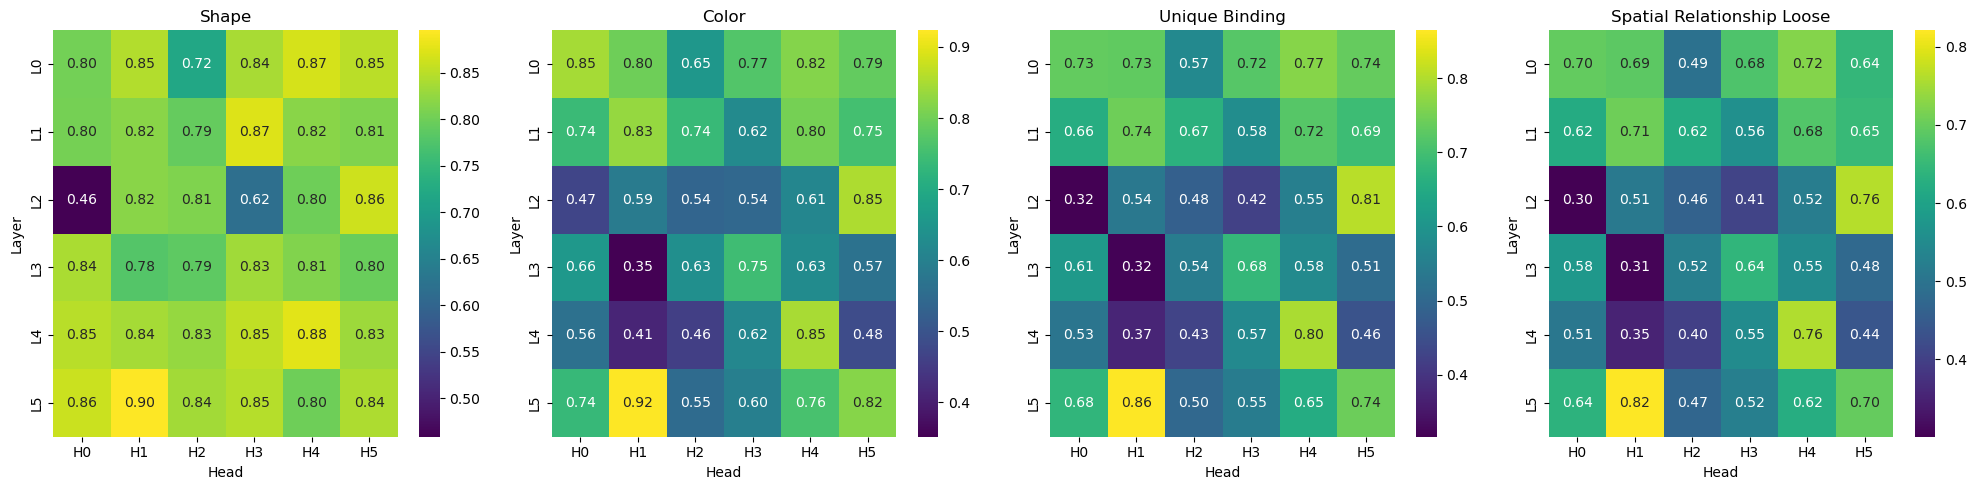

In [126]:
# Organize the results into heatmaps

import matplotlib.pyplot as plt
import seaborn as sns


# Extract available layers and heads
layers = sorted(all_prompt_head_ablation_results_df['target_layer'].unique())
head_tuples = all_prompt_head_ablation_results_df['target_head_indices'].unique()
# Find number of heads by inspecting all tuples
head_indices = sorted({idx for tpl in head_tuples for idx in (tpl if isinstance(tpl, tuple) else (tpl,))})
num_heads = max(head_indices) + 1 if head_indices else 0

# For each metric, build a (layer x head) matrix
metrics = [
    'shape', 'color', 'unique_binding', 'spatial_relationship_loose'
    # 'overall', 'overall_loose',
    # 'shape', 'color', 'exist_binding', 'unique_binding',
    # 'spatial_relationship', 'spatial_relationship_loose'
]

def get_metric_matrix(df, metric):
    mat = np.full((len(layers), num_heads), np.nan)
    for i, layer in enumerate(layers):
        for j in range(num_heads):
            row = df[
                (df['target_layer'] == layer) &
                (df['target_head_indices'] == (j,))
            ]
            if not row.empty:
                mat[i, j] = row[metric].mean()
    return mat

# Plot heatmaps for each metric
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    mat = get_metric_matrix(all_prompt_head_ablation_results_df, metric)
    sns.heatmap(
        mat, annot=True, fmt=".2f", cmap="viridis", cbar=True,
        ax=axes[idx],
        xticklabels=[f"H{h}" for h in range(num_heads)],
        yticklabels=[f"L{l}" for l in layers]
    )
    axes[idx].set_title(metric.replace("_", " ").title())
    axes[idx].set_xlabel("Head")
    axes[idx].set_ylabel("Layer")

plt.tight_layout()
saveallforms(figdir, f"all_prompt_head_ablation_results_all_heads_heatmaps")
plt.show()


In [127]:
all_prompt_head_ablation_summary_df = all_prompt_head_ablation_results_df.groupby(["target_layer", "target_head_indices"], sort=False).\
                    mean(numeric_only=True).drop(columns=['prompt_id', 'sample_id'], errors='ignore')

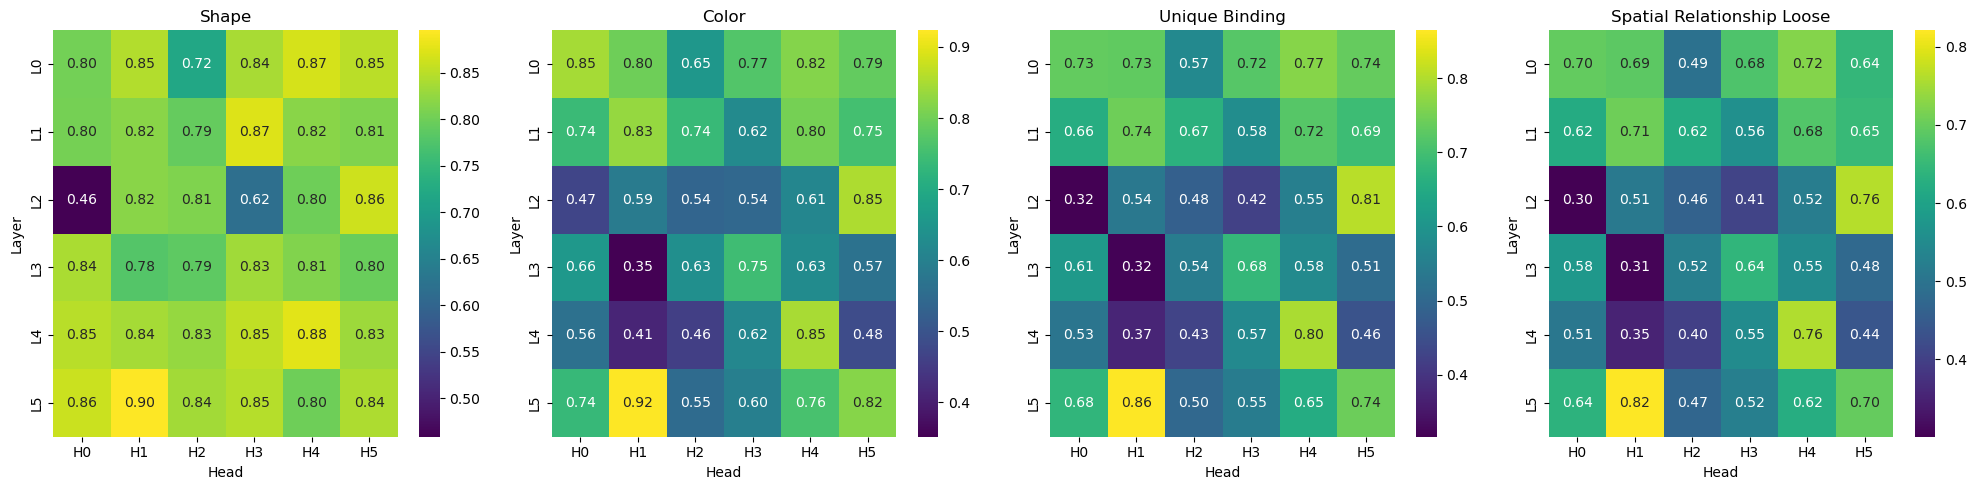

In [129]:
# Organize the results into heatmaps

import matplotlib.pyplot as plt
import seaborn as sns
all_prompt_head_ablation_summary_df = all_prompt_head_ablation_summary_df.reset_index()

# Extract available layers and heads
layers = sorted(all_prompt_head_ablation_summary_df['target_layer'].unique())
head_tuples = all_prompt_head_ablation_summary_df['target_head_indices'].unique()
# Find number of heads by inspecting all tuples
head_indices = sorted({idx for tpl in head_tuples for idx in (tpl if isinstance(tpl, tuple) else (tpl,))})
num_heads = max(head_indices) + 1 if head_indices else 0

# For each metric, build a (layer x head) matrix
metrics = [
    'shape', 'color', 'unique_binding', 'spatial_relationship_loose'
    # 'overall', 'overall_loose',
    # 'shape', 'color', 'exist_binding', 'unique_binding',
    # 'spatial_relationship', 'spatial_relationship_loose'
]

def get_metric_matrix(df, metric):
    mat = np.full((len(layers), num_heads), np.nan)
    for i, layer in enumerate(layers):
        for j in range(num_heads):
            row = df[
                (df['target_layer'] == layer) &
                (df['target_head_indices'] == (j,))
            ]
            if not row.empty:
                mat[i, j] = row[metric].mean()
    return mat

# Plot heatmaps for each metric
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    mat = get_metric_matrix(all_prompt_head_ablation_results_df, metric)
    sns.heatmap(
        mat, annot=True, fmt=".2f", cmap="viridis", cbar=True,
        ax=axes[idx],
        xticklabels=[f"H{h}" for h in range(num_heads)],
        yticklabels=[f"L{l}" for l in layers]
    )
    axes[idx].set_title(metric.replace("_", " ").title())
    axes[idx].set_xlabel("Head")
    axes[idx].set_ylabel("Layer")

plt.tight_layout()
# saveallforms(figdir, f"all_prompt_head_ablation_results_all_heads_heatmaps")
plt.show()
